GSGD CNN

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from model import CNN_GSGD, GSGDOptimizer
from train import train, test
import os
import torch.nn as nn
from torch.utils.data import random_split

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

HISTOGRAM

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Path to the ZIP file
zip_file_path = '/content/drive/My Drive/Twitter Depression - Results/Histogram.zip'
extract_path = '/content/'

# Verify if the ZIP file exists
if not os.path.exists(zip_file_path):
    raise FileNotFoundError(f"File not found: {zip_file_path}")

# Copy the ZIP file to Colab
!cp "{zip_file_path}" /content

# Unzip the file
with zipfile.ZipFile('/content/Histogram.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the path to the folder where your images are stored
data_path = '/content/Histogram'  # Update this with the path to your images

# Step 1: Set up transformations (similar to MNIST preprocessing)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale if needed
    # transforms.Resize((28, 28)),  # Resize to 28x28 to match MNIST dimensions, adjust if needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to match MNIST-like preprocessing
])

# Step 2: Load the entire dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Step 3: Get input size dynamically from the first image in the dataset
sample_image, _ = full_dataset[0]  # Take the first image to determine the input shape
input_size = sample_image.shape  # This will be (C, H, W)

# Step 4: Split the dataset into training and testing sets
train_size = int(0.8 * len(full_dataset))  # 80% for training
test_size = len(full_dataset) - train_size  # Remaining 20% for testing
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Step 5: Create DataLoaders for both sets
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Split the train_dataset into training and validation datasets
train_size = int(0.8 * len(train_dataset))  # 80% for training
validation_size = len(train_dataset) - train_size  # Remaining 20% for validation
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_GSGD(input_size=input_size, num_classes=len(full_dataset.classes)).to(device)

# model = EnhancedCNN_GSGD(num_classes=len(full_dataset.classes)).to(device)


# For Standard Guided SGD
# optimizer = GSGDOptimizer(model.parameters(), lr=0.01, method='sgd')

# For Guided SGD with Momentum
optimizer = GSGDOptimizer(model.parameters(), lr=0.01, method='momentum', momentum=0.9)

# For Guided Adam
# optimizer = GSGDOptimizer(model.parameters(), lr=0.001, method='adam', beta1=0.9, beta2=0.999)

In [ ]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Run training for each epoch, passing the dataset instead of DataLoader
for epoch in range(1, 30):
    train(model, device, train_loader.dataset, validation_loader.dataset, optimizer, epoch, loss_fn,
      verification_set_num=4, rho=10, log_interval=9)
    # train(model, device, train_loader.dataset, optimizer, epoch, loss_fn)  # Pass train_loader.dataset
    test(model, device, test_loader)

Epoch: 1, Iteration: 1, Loss: 0.683789
Epoch: 1, Iteration: 10, Loss: 0.689601
Epoch: 1, Iteration: 19, Loss: 0.696549
Epoch: 1, Iteration: 28, Loss: 0.698430
Epoch: 1, Iteration: 37, Loss: 0.692118
Epoch: 1, Iteration: 46, Loss: 0.682350
Epoch: 1, Iteration: 55, Loss: 0.692389
Epoch: 1, Iteration: 64, Loss: 0.692657
Epoch: 1, Iteration: 73, Loss: 0.684886
Epoch: 1, Iteration: 82, Loss: 0.695700
Epoch: 1, Iteration: 91, Loss: 0.694958
Epoch: 1, Iteration: 100, Loss: 0.699662
Epoch: 1, Iteration: 109, Loss: 0.698545
Epoch: 1, Iteration: 118, Loss: 0.692767
Epoch: 1, Iteration: 127, Loss: 0.692377
Epoch: 1, Iteration: 136, Loss: 0.696613
Epoch: 1, Iteration: 145, Loss: 0.690303
Epoch: 1, Iteration: 154, Loss: 0.689444
Epoch 1 completed.

Test set: Average loss: 0.0009, Accuracy: 1590/3200 (50%)

Epoch: 2, Iteration: 1, Loss: 0.693141
Epoch: 2, Iteration: 10, Loss: 0.696811
Epoch: 2, Iteration: 19, Loss: 0.683612
Epoch: 2, Iteration: 28, Loss: 0.700852
Epoch: 2, Iteration: 37, Loss: 0.694

In [ ]:
# Save the trained model
model_save_path = '/content/histogram_model.pth'  # Path where you want to save the model
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to /content/histogram_model.pth


<ipython-input-20-4ae14c43a8ba>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/histogram_model.pth'))


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.86      0.77      1610
           1       0.82      0.63      0.71      1590

    accuracy                           0.75      3200
   macro avg       0.76      0.75      0.74      3200
weighted avg       0.76      0.75      0.74      3200



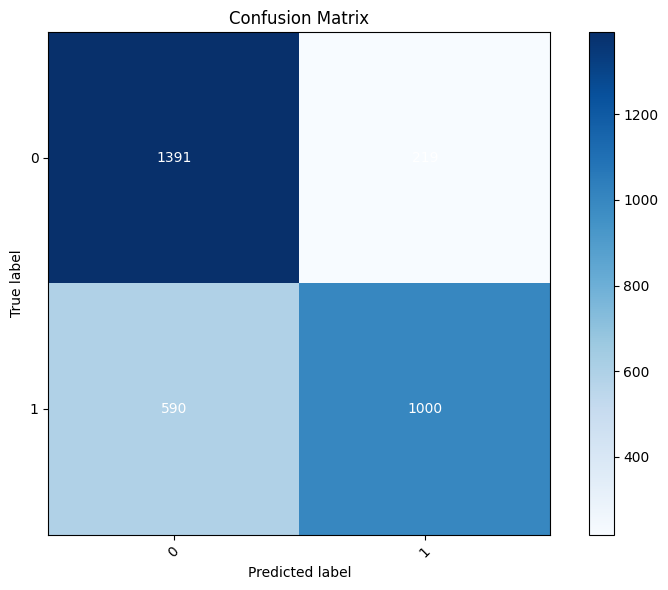

Confusion Matrix:
[[1391  219]
 [ 590 1000]]

ROC Values:
Class 1: AUC = 0.85


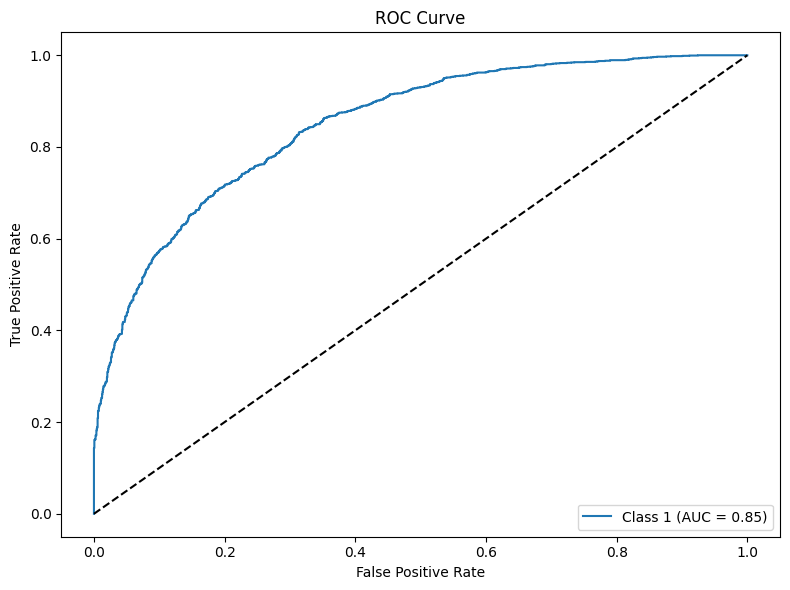

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import torch.nn.functional as F  # For softmax

# Load the trained model
model = CNN_GSGD(input_size=input_size, num_classes=len(full_dataset.classes)).to(device)
model.load_state_dict(torch.load('/content/histogram_model.pth'))
model.eval()

# Get predictions and true labels for the test set
all_preds = []
all_labels = []
all_preds_prob = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, preds = torch.max(output, 1)  # Get predictions
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())
        all_preds_prob.extend(F.softmax(output, dim=1).cpu().numpy())  # Store probabilities

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Confusion Matrix
cf_matrix = confusion_matrix(all_labels, all_preds)

# Visualizing Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = list(full_dataset.classes)  # Assuming the class labels are present in the dataset
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add annotations to the confusion matrix
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cf_matrix[i, j]), ha='center', va='center', color='white')

plt.tight_layout()
plt.show()  # Display confusion matrix plot

# Print Confusion Matrix values
print("Confusion Matrix:")
print(cf_matrix)

# Determine if it's binary or multi-class
is_binary = len(classes) == 2  # If there are only two classes, it's binary classification

# Compute ROC Curve and AUC
lb = LabelBinarizer()
all_labels_bin = lb.fit_transform(all_labels)  # Convert labels to binary format

fpr = dict()
tpr = dict()
roc_auc = dict()

if is_binary:
    # For binary classification, we only need the positive class (class 1)
    fpr, tpr, _ = roc_curve(all_labels_bin, np.array(all_preds_prob)[:, 1])  # Get probabilities for class 1
    roc_auc = auc(fpr, tpr)
else:
    # For multi-class classification, compute ROC for each class
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_preds_prob)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

# Print ROC values
print("\nROC Values:")
if is_binary:
    print(f'Class 1: AUC = {roc_auc:.2f}')
else:
    for i in range(len(classes)):
        print(f'Class {classes[i]}: AUC = {roc_auc[i]:.2f}')

# Plot ROC curve
plt.figure(figsize=(8, 6))
if is_binary:
    plt.plot(fpr, tpr, label=f'Class 1 (AUC = {roc_auc:.2f})')
else:
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (no discrimination)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()  # Display ROC curve plot


BAR GRAPHS

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Path to the ZIP file
zip_file_path = '/content/drive/My Drive/Twitter Depression - Results/bargraphs.zip'
extract_path = '/content/bargraphs'

# Verify if the ZIP file exists
if not os.path.exists(zip_file_path):
    raise FileNotFoundError(f"File not found: {zip_file_path}")

# Copy the ZIP file to Colab
!cp "{zip_file_path}" /content

# Unzip the file
with zipfile.ZipFile('/content/bargraphs.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the path to the folder where your images are stored
data_path = '/content/bargraphs'  # Update this with the path to your images

# Step 1: Set up transformations (similar to MNIST preprocessing)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale if needed
    # transforms.Resize((28, 28)),  # Resize to 28x28 to match MNIST dimensions, adjust if needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to match MNIST-like preprocessing
])

# Step 2: Load the entire dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Step 3: Get input size dynamically from the first image in the dataset
sample_image, _ = full_dataset[0]  # Take the first image to determine the input shape
input_size = sample_image.shape  # This will be (C, H, W)

# Step 4: Split the dataset into training and testing sets
train_size = int(0.8 * len(full_dataset))  # 80% for training
test_size = len(full_dataset) - train_size  # Remaining 20% for testing
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Step 5: Create DataLoaders for both sets
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Split the train_dataset into training and validation datasets
train_size = int(0.8 * len(train_dataset))  # 80% for training
validation_size = len(train_dataset) - train_size  # Remaining 20% for validation
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_GSGD(input_size=input_size, num_classes=len(full_dataset.classes)).to(device)

# model = EnhancedCNN_GSGD(num_classes=len(full_dataset.classes)).to(device)


# For Standard Guided SGD
# optimizer = GSGDOptimizer(model.parameters(), lr=0.01, method='sgd')

# For Guided SGD with Momentum
optimizer = GSGDOptimizer(model.parameters(), lr=0.01, method='momentum', momentum=0.9)

# For Guided Adam
# optimizer = GSGDOptimizer(model.parameters(), lr=0.001, method='adam', beta1=0.9, beta2=0.999)


# Define the loss function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Run training for each epoch, passing the dataset instead of DataLoader
for epoch in range(1, 30):
    train(model, device, train_loader.dataset, validation_loader.dataset, optimizer, epoch, loss_fn,
      verification_set_num=4, rho=10, log_interval=9)
    # train(model, device, train_loader.dataset, optimizer, epoch, loss_fn)  # Pass train_loader.dataset
    test(model, device, test_loader)


Epoch: 1, Iteration: 1, Loss: 0.692356
Epoch: 1, Iteration: 10, Loss: 0.693033
Epoch: 1, Iteration: 19, Loss: 0.676657
Epoch: 1, Iteration: 28, Loss: 0.695040
Epoch: 1, Iteration: 37, Loss: 0.712337
Epoch: 1, Iteration: 46, Loss: 0.690217
Epoch: 1, Iteration: 55, Loss: 0.687869
Epoch: 1, Iteration: 64, Loss: 0.702819
Epoch: 1, Iteration: 73, Loss: 0.707224
Epoch: 1, Iteration: 82, Loss: 0.684439
Epoch: 1, Iteration: 91, Loss: 0.688110
Epoch: 1, Iteration: 100, Loss: 0.687047
Epoch: 1, Iteration: 109, Loss: 0.666485
Epoch: 1, Iteration: 118, Loss: 0.674273
Epoch: 1, Iteration: 127, Loss: 0.701611
Epoch: 1, Iteration: 136, Loss: 0.652864
Epoch: 1, Iteration: 145, Loss: 0.682595
Epoch: 1, Iteration: 154, Loss: 0.668389
Epoch 1 completed.

Test set: Average loss: 0.0008, Accuracy: 1969/3200 (62%)

Epoch: 2, Iteration: 1, Loss: 0.648892
Epoch: 2, Iteration: 10, Loss: 0.657898
Epoch: 2, Iteration: 19, Loss: 0.607509
Epoch: 2, Iteration: 28, Loss: 0.748380
Epoch: 2, Iteration: 37, Loss: 0.627

In [ ]:
# Save the trained model
model_save_path = '/content/bargraph_model.pth'  # Path where you want to save the model
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to /content/bargraph_model.pth


<ipython-input-31-6e1f1e8f9b0b>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/bargraph_model.pth'))


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.75      0.71      1645
           1       0.70      0.63      0.66      1555

    accuracy                           0.69      3200
   macro avg       0.69      0.69      0.69      3200
weighted avg       0.69      0.69      0.69      3200



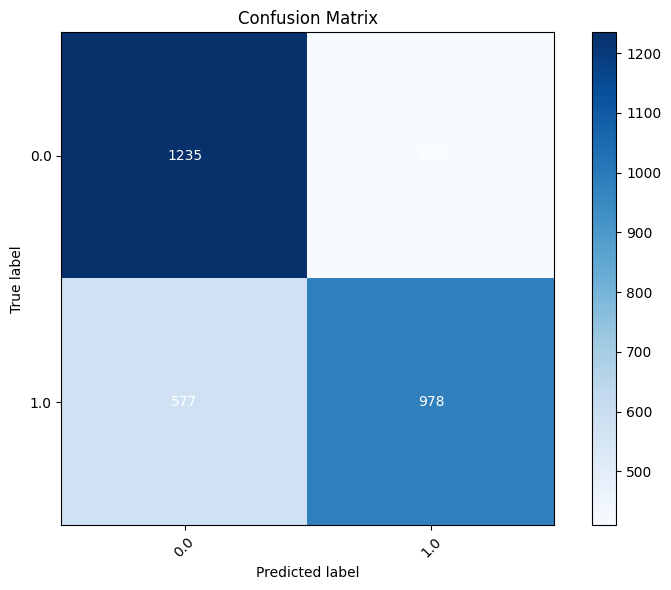

Confusion Matrix:
[[1235  410]
 [ 577  978]]

ROC Values:
Class 1: AUC = 0.77


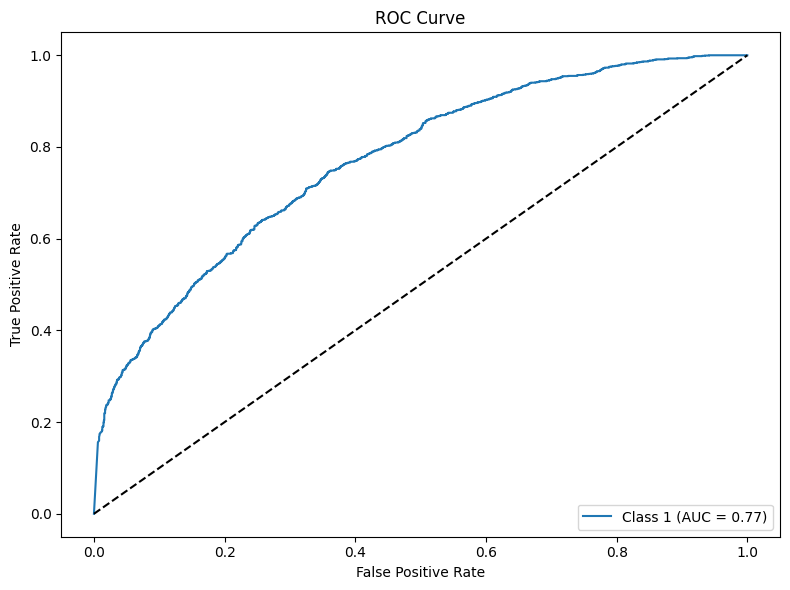

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import torch.nn.functional as F  # For softmax

# Load the trained model
model = CNN_GSGD(input_size=input_size, num_classes=len(full_dataset.classes)).to(device)
model.load_state_dict(torch.load('/content/bargraph_model.pth'))
model.eval()

# Get predictions and true labels for the test set
all_preds = []
all_labels = []
all_preds_prob = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, preds = torch.max(output, 1)  # Get predictions
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())
        all_preds_prob.extend(F.softmax(output, dim=1).cpu().numpy())  # Store probabilities

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Confusion Matrix
cf_matrix = confusion_matrix(all_labels, all_preds)

# Visualizing Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = list(full_dataset.classes)  # Assuming the class labels are present in the dataset
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add annotations to the confusion matrix
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cf_matrix[i, j]), ha='center', va='center', color='white')

plt.tight_layout()
plt.show()  # Display confusion matrix plot

# Print Confusion Matrix values
print("Confusion Matrix:")
print(cf_matrix)

# Determine if it's binary or multi-class
is_binary = len(classes) == 2  # If there are only two classes, it's binary classification

# Compute ROC Curve and AUC
lb = LabelBinarizer()
all_labels_bin = lb.fit_transform(all_labels)  # Convert labels to binary format

fpr = dict()
tpr = dict()
roc_auc = dict()

if is_binary:
    # For binary classification, we only need the positive class (class 1)
    fpr, tpr, _ = roc_curve(all_labels_bin, np.array(all_preds_prob)[:, 1])  # Get probabilities for class 1
    roc_auc = auc(fpr, tpr)
else:
    # For multi-class classification, compute ROC for each class
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_preds_prob)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

# Print ROC values
print("\nROC Values:")
if is_binary:
    print(f'Class 1: AUC = {roc_auc:.2f}')
else:
    for i in range(len(classes)):
        print(f'Class {classes[i]}: AUC = {roc_auc[i]:.2f}')

# Plot ROC curve
plt.figure(figsize=(8, 6))
if is_binary:
    plt.plot(fpr, tpr, label=f'Class 1 (AUC = {roc_auc:.2f})')
else:
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (no discrimination)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()  # Display ROC curve plot

HEATMAPS

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Path to the ZIP file
zip_file_path = '/content/drive/My Drive/Twitter Depression - Results/heatmaps.zip'
extract_path = '/content/heatmaps'

# Verify if the ZIP file exists
if not os.path.exists(zip_file_path):
    raise FileNotFoundError(f"File not found: {zip_file_path}")

# Copy the ZIP file to Colab
!cp "{zip_file_path}" /content

# Unzip the file
with zipfile.ZipFile('/content/heatmaps.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the path to the folder where your images are stored
data_path = '/content/heatmaps'  # Update this with the path to your images

# Step 1: Set up transformations (similar to MNIST preprocessing)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale if needed
    # transforms.Resize((28, 28)),  # Resize to 28x28 to match MNIST dimensions, adjust if needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to match MNIST-like preprocessing
])

# Step 2: Load the entire dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Step 3: Get input size dynamically from the first image in the dataset
sample_image, _ = full_dataset[0]  # Take the first image to determine the input shape
input_size = sample_image.shape  # This will be (C, H, W)

# Step 4: Split the dataset into training and testing sets
train_size = int(0.8 * len(full_dataset))  # 80% for training
test_size = len(full_dataset) - train_size  # Remaining 20% for testing
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Step 5: Create DataLoaders for both sets
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Split the train_dataset into training and validation datasets
train_size = int(0.8 * len(train_dataset))  # 80% for training
validation_size = len(train_dataset) - train_size  # Remaining 20% for validation
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_GSGD(input_size=input_size, num_classes=len(full_dataset.classes)).to(device)

# model = EnhancedCNN_GSGD(num_classes=len(full_dataset.classes)).to(device)
# For Standard Guided SGD
# optimizer = GSGDOptimizer(model.parameters(), lr=0.01, method='sgd')

# For Guided SGD with Momentum
optimizer = GSGDOptimizer(model.parameters(), lr=0.01, method='momentum', momentum=0.9)

# For Guided Adam
# optimizer = GSGDOptimizer(model.parameters(), lr=0.001, method='adam', beta1=0.9, beta2=0.999)

In [ ]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Run training for each epoch, passing the dataset instead of DataLoader
for epoch in range(1, 30):
    train(model, device, train_loader.dataset, validation_loader.dataset, optimizer, epoch, loss_fn,
      verification_set_num=4, rho=10, log_interval=2)
    # train(model, device, train_loader.dataset, optimizer, epoch, loss_fn)  # Pass train_loader.dataset
    test(model, device, test_loader)

Epoch: 1, Iteration: 1, Loss: 0.692652
Epoch: 1, Iteration: 3, Loss: 0.682814
Epoch: 1, Iteration: 5, Loss: 0.716127
Epoch: 1, Iteration: 7, Loss: 0.693756
Epoch: 1, Iteration: 9, Loss: 0.701521
Epoch: 1, Iteration: 11, Loss: 0.718127
Epoch: 1, Iteration: 13, Loss: 0.691037
Epoch: 1, Iteration: 15, Loss: 0.683663
Epoch: 1, Iteration: 17, Loss: 0.695137
Epoch: 1, Iteration: 19, Loss: 0.696320
Epoch: 1, Iteration: 21, Loss: 0.692889
Epoch: 1, Iteration: 23, Loss: 0.687982
Epoch: 1, Iteration: 25, Loss: 0.689128
Epoch: 1, Iteration: 27, Loss: 0.700045
Epoch: 1, Iteration: 29, Loss: 0.700673
Epoch: 1, Iteration: 31, Loss: 0.695725
Epoch: 1, Iteration: 33, Loss: 0.695598
Epoch: 1, Iteration: 35, Loss: 0.694411
Epoch: 1, Iteration: 37, Loss: 0.691606
Epoch: 1, Iteration: 39, Loss: 0.692862
Epoch: 1, Iteration: 41, Loss: 0.694875
Epoch: 1, Iteration: 43, Loss: 0.691421
Epoch: 1, Iteration: 45, Loss: 0.690501
Epoch: 1, Iteration: 47, Loss: 0.691878
Epoch: 1, Iteration: 49, Loss: 0.695237
Epoch

In [ ]:
# Save the trained model
model_save_path = '/content/heatmaps_model.pth'  # Path where you want to save the model
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to /content/heatmaps_model.pth


<ipython-input-37-eac103c8114b>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/heatmaps_model.pth'))


Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.74      0.68      1628
           1       0.68      0.55      0.61      1572

    accuracy                           0.65      3200
   macro avg       0.66      0.65      0.65      3200
weighted avg       0.65      0.65      0.65      3200



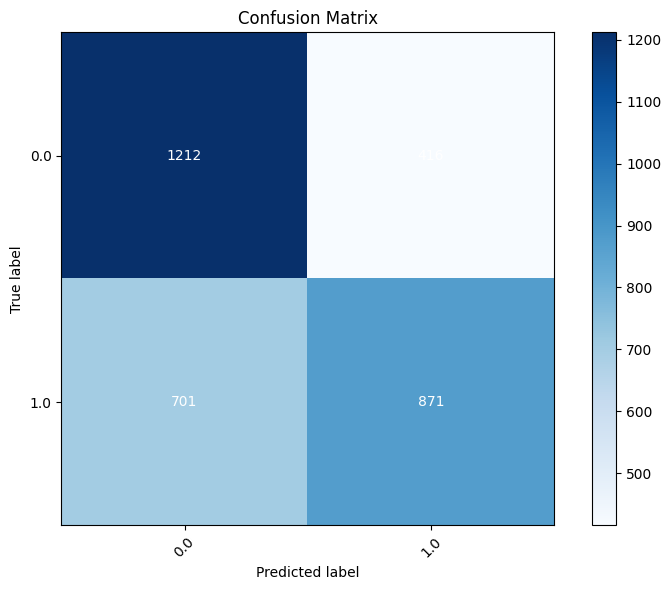

Confusion Matrix:
[[1212  416]
 [ 701  871]]

ROC Values:
Class 1: AUC = 0.72


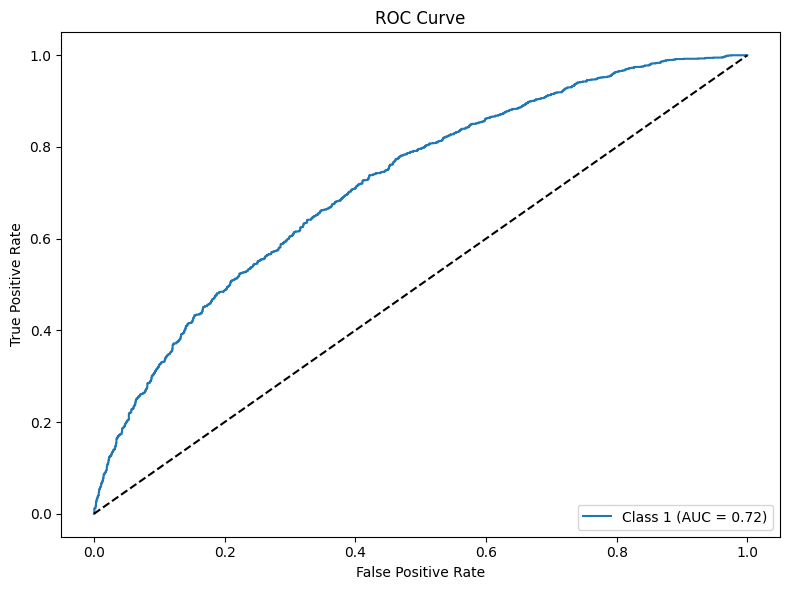

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import torch.nn.functional as F  # For softmax

# Load the trained model
model = CNN_GSGD(input_size=input_size, num_classes=len(full_dataset.classes)).to(device)
model.load_state_dict(torch.load('/content/heatmaps_model.pth'))
model.eval()

# Get predictions and true labels for the test set
all_preds = []
all_labels = []
all_preds_prob = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, preds = torch.max(output, 1)  # Get predictions
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())
        all_preds_prob.extend(F.softmax(output, dim=1).cpu().numpy())  # Store probabilities

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Confusion Matrix
cf_matrix = confusion_matrix(all_labels, all_preds)

# Visualizing Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = list(full_dataset.classes)  # Assuming the class labels are present in the dataset
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add annotations to the confusion matrix
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cf_matrix[i, j]), ha='center', va='center', color='white')

plt.tight_layout()
plt.show()  # Display confusion matrix plot

# Print Confusion Matrix values
print("Confusion Matrix:")
print(cf_matrix)

# Determine if it's binary or multi-class
is_binary = len(classes) == 2  # If there are only two classes, it's binary classification

# Compute ROC Curve and AUC
lb = LabelBinarizer()
all_labels_bin = lb.fit_transform(all_labels)  # Convert labels to binary format

fpr = dict()
tpr = dict()
roc_auc = dict()

if is_binary:
    # For binary classification, we only need the positive class (class 1)
    fpr, tpr, _ = roc_curve(all_labels_bin, np.array(all_preds_prob)[:, 1])  # Get probabilities for class 1
    roc_auc = auc(fpr, tpr)
else:
    # For multi-class classification, compute ROC for each class
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_preds_prob)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

# Print ROC values
print("\nROC Values:")
if is_binary:
    print(f'Class 1: AUC = {roc_auc:.2f}')
else:
    for i in range(len(classes)):
        print(f'Class {classes[i]}: AUC = {roc_auc[i]:.2f}')

# Plot ROC curve
plt.figure(figsize=(8, 6))
if is_binary:
    plt.plot(fpr, tpr, label=f'Class 1 (AUC = {roc_auc:.2f})')
else:
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (no discrimination)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()  # Display ROC curve plot